In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from uuid import uuid4

import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels import api as sm

import bhutils
from api.blpw import BlpQuery
from api.history_plotter import get_expressions_data
from api.tools import get_history_plotter_strings
from api.utils import parse_offset
from api.mappings import strategy_map

In [3]:
import json
import sys
import re
import logging
import os
from pathlib import Path
from functools import partial
from itertools import chain
from uuid import uuid4

import blpapi
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr, VegaExpr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots

import bhutils
from bhutils import bhutilspy as bh
from api.ezutils import bh, mkt_defs, ccy_cals, mx_cals, mtg_dts, gens

from api.utils import parse_offset, today, get_next_n
from api.data.base import data_path, radar_path
from api.gui.base import View, store
from api.gui.params import curves, bbg_params, spot_params, fwd_params
from api.blpw import BlpQuery
from api.gui.radar import RepeatedTimer
from api import giobhutils as gio
from api.gui.theme import bg_color, grid_style
from api.gui.pandas import DFOutput, negative_red, custom_styler_row_line

pd.options.plotting.backend = "plotly"

In [4]:
from api.gui.collectors import DataCollector, SpotForward, Futures, Market, Mtgs, FwdMatrix
from api.gui.radar2 import EditableGrid
from api.gui.tables import SpotTable, FutureTable, GroupMktTalbe, KeyChart, MtgTable, MatTable, CustomGovtBondFutTable

In [321]:
bq = BlpQuery(timeout=50000).start()

In [394]:
r = get_history_plotter_strings( 
    delta_mul=1, 
    delta_tol=499
)

C:\dev\projects\menashe\api\tools.py:204: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [184]:
expressions = r[-1].to_dict()
expressions

{'eur_cur': '-0.8*[s eur 170mx5y] +1.1*[s eur 74mx3y]',
 'eur_fly_sp': '+15.1*[s eur 116mx2y] -7.6*[s eur 176mx5y] -9.4*[s eur 21mx2y] +4.5*[s eur 45mx3y] -7.6*[s eur 92mx2y] +4.9*[s eur 9mx1y]',
 'eur_hed': '+7.2*[s eur 83mx2y] +1.2*[s eur.3m 17mx3m] -1.2*[s eur.3m 5mx3m] -11.3*[s eur.ester 2mx104m]',
 'eur_ope_op': '+0.5*[s EUR.ESTER 14mx3m] +0.8*[s EUR.ESTER 17mx3m] +0.1*[s eur 67mx5y]',
 'gbp_hed': '+0.5*[s gbp.sonia 14mx3m]',
 'usd_cur': '+11.4*[s usd.sofr 35mx10y] -13.8*[s usd.sofr 35mx359m]',
 'usd_hed': '+5.0*[s usd 11mx3m] +5.0*[s usd 14mx3m] -10.0*[s usd 23mx3m] -10.0*[s usd 26mx3m] +4.9*[s usd 35mx3m] +4.9*[s usd 38mx3m]',
 'usd_ope_op': '+1.7*[s usd 20mx3m] -1.3*[s usd.sofr 3mx78m]',
 'usd_sho_cu': '+1.5*[s usd 11mx3m] +0.5*[s usd 17mx3m] -2.5*[s usd 23mx3m] -0.8*[s usd 29mx3m]',
 'eur_curA': '-0.8*[s eur 167mx5y] +1.1*[s eur 71mx3y]',
 'eur_fly_spA': '+15.1*[s eur 113mx2y] -7.6*[s eur 173mx5y] -9.4*[s eur 18mx2y] +4.5*[s eur 42mx3y] -7.6*[s eur 89mx2y] +4.9*[s eur 6mx1y]',

In [14]:
data = pd.read_clipboard(header=None)
ptf = data.set_index(0).dropna().squeeze().rename('ptf')
ptf.index = pd.to_datetime(ptf.index)
ptf = ptf.sort_index()

In [54]:
tickers = [
    'EDU3 Comdty',
    'EDU4 Comdty',
    'RX1 Comdty',
    'TY1 Comdty'
]

In [55]:
end_date = today() - BDay()
start_date = end_date - parse_offset('2y')

In [56]:
reg = bq.bdh(
    securities=tickers,
    fields=['px_last'],
    start_date=start_date,
    end_date=end_date
).dropna().infer_objects()

In [66]:
X.diff().corr()

security     EDU3 Comdty  EDU4 Comdty  RX1 Comdty  TY1 Comdty
security                                                     
EDU3 Comdty     1.000000     0.932614    0.550974    0.858409
EDU4 Comdty     0.932614     1.000000    0.582266    0.934977
RX1 Comdty      0.550974     0.582266    1.000000    0.608181
TY1 Comdty      0.858409     0.934977    0.608181    1.000000

In [68]:
ptf.plot(height=500)

In [59]:
X = reg.set_index('date').pivot(columns='security', values='px_last').dropna()

In [60]:
def get_df_reg(X, y, diff=False, history=None):
    if diff:
        X = X.diff().dropna()
        y = y.diff().dropna()
    if history:
        X = X.loc[X.index[-1] - parse_offset(history):, :]
        y = y.loc[y.index[-1] - parse_offset(history):]
    df_reg = pd.concat([X, y], axis=1).ffill()
    return df_reg

In [90]:
df_reg = get_df_reg(
    X=X[['EDU3 Comdty']], 
    y=ptf,
    diff=True,
    history='6m'
)

In [76]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);

In [77]:
y_pred = pd.Series(lm.predict(df_reg.iloc[:, :-1]), index=df_reg.iloc[:, :-1].index, name='pred')

In [78]:
f"params: {lm.coef_}, intercept: {lm.intercept_}, r2: {lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])}"

'params: [-3.4973037], intercept: 0.0, r2: 0.1693426092930368'

In [ ]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);
f"params: {lm.coef_}, intercept: {lm.intercept_}, r2: {lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])}"

In [81]:
pd.Series(lm.coef_)

0   -3.497304
dtype: float64

In [84]:
pd.Series(lm.coef_, index=df_reg.columns[:-1]) 

EDU3 Comdty   -3.497304
dtype: float64

In [85]:
(pd.Series(lm.coef_, index=df_reg.columns[:-1]) * -10000).round(0)

EDU3 Comdty    34973.0
dtype: float64

In [89]:
(lm.coef_) / 25 * 10000

array([-1398.92147927])

In [ ]:
df_reg.plot.scatter(x='x', y='y', backend='plotly')

In [ ]:
pd.concat([df_reg['y'], y_pred], axis=1).plot.scatter(x='y', y='pred', backend='plotly')

In [ ]:
ols = sm.OLS(df_reg.iloc[:, -1], sm.add_constant(df_reg.iloc[:, :-1]))

In [ ]:
reso = ols.fit()

In [ ]:
reso.summary()

In [ ]:
reso.summary2()

In [110]:
cols = [
    'Term',
    '$FWD Delta Total Positions',
    'Effective Date',
    'Maturity Date'
    
]

In [111]:
usd = pd.read_clipboard(skiprows=3, sep='\t', header=0)[cols].rename({'$FWD Delta Total Positions': 'delta'}, axis=1)
usd['delta'] = usd['delta'].astype(str).str.replace(',', '').astype(float)

In [112]:
eur = pd.read_clipboard(skiprows=3, sep='\t', header=0)[cols].rename({'$FWD Delta Total Positions': 'delta'}, axis=1)
eur['delta'] = eur['delta'].astype(str).str.replace(',', '').astype(float)

In [159]:
usd = usd.rename({'$FWD Delta Total Positions': 'delta'}, axis=1)

In [182]:
from api import utils as u
from api import tools as t 

In [132]:
ccy_fut_map = {
    'USD': 'ED',
    'EUR': 'ER'
}

In [140]:
n = 12
futures = pd.Series(range(1, n + 1), index=u.get_next_n(n, False))

In [124]:
ccy = 'eur'

In [236]:
def get_history_plotter_code(df, ccy, fut=True):
    codes = []
    for index, row in df.iterrows():
        term = row['Term']
    
        if term != 'STUB':
            term_ = term.split(' ')[0]
            try:
                check = int(term_[0])
                code = f"[s {ccy} {term_}]"
            except:
                if fut:
                    fut_code = ccy_fut_map[ccy.upper()]
                    code = f"[fut {fut_code} {futures[term_]}]"
                else:
                    code = f"[s {ccy} {t.parse_swap_periods(row['Effective Date'], row['Maturity Date'])}]"    
        else:
            code = None
        codes.append(code)
    
    return df.assign(code=codes).dropna()
    

In [355]:
def parse_df(ccy, delta_tol=500, fut=False, delta_mul=1):
    df = pd.read_clipboard(skiprows=3, sep='\t', header=0)[cols].rename({'$FWD Delta Total Positions': 'delta'}, axis=1)
    df['delta'] = df['delta'].astype(str).str.replace(',', '').astype(float)
    df['Effective Date'] = pd.to_datetime(df['Effective Date'])
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
    df = get_history_plotter_code(df, ccy=ccy, fut=fut, delta_mul=delta_mul)
    df = df.sort_values('delta')
    df = df.loc[~df['delta'].between(-delta_tol, delta_tol)]
    return df 

In [356]:
delta_tol = 500
bpv = 10000

In [359]:
def get_agg(df, ccy, delta_mul=1):
    split = {
        f'{ccy}+': '',
        f'{ccy}-': ''
    }
    for index, row in df.iterrows():
        key = f'{ccy}+' if row['delta'] > 0 else f'{ccy}-'
        split[key] = split[key] + f"{row['delta'] / bpv * delta_mul:+.1f}*{row['code']}"
    
    return split

In [358]:
eur = parse_df('eur', fut=False)
split_eur = get_agg(eur, 'eur')

EmptyDataError: No columns to parse from file

In [260]:
usd = parse_df('usd', fut=False)
split_usd = get_agg(usd, 'usd')

In [271]:
hp_string = pd.DataFrame([split_eur, split_usd]).ffill().dropna().T.squeeze().rename(None)
hp_string.to_clipboard(header=False)

In [403]:
def read_hp_ts(columns=None):
    data = pd.read_clipboard(header=None)
    data = data.dropna(how='all', axis=1).dropna().T.reset_index(drop=True).T
    data = pd.concat([data.iloc[:, i:i+2].set_index(i).squeeze() for i in range(0, data.shape[1], 2)], axis=1)
    if columns is not None:
        data = data.set_axis(columns, axis=1)
    data.index = pd.to_datetime(data.index)
    return data.sort_index().astype(float).dropna()

In [337]:
data = read_hp_ts(hp_string.index)

In [ ]:
base_tickers = 

In [318]:
tickers = [f"{v}{exp} Comdty" for v in curr_fut_map.values() for exp in get_next_n(12)]

In [319]:
end_date = today() - BDay()
start_date = end_date - parse_offset('2y')

In [328]:
reg = bq.bdh(
    securities=tickers,
    fields=['px_last'],
    start_date=start_date,
    end_date=end_date
).dropna().infer_objects()

In [ ]:
X = reg.pivot(index='date', columns='security', values='px_last')

In [373]:
h = '6m'
res = {}
df_regs = {}
for y_name in data:
    y = data[y_name]
    for x_name in X:
        df_reg = get_df_reg(
            X=X[[x_name]], 
            y=y,
            diff=True,
            history=h
        )
        df_regs[(y_name, x_name)] = df_reg
        lm = LinearRegression(fit_intercept=False)
        lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);
        r2 = lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])
        coef = lm.coef_[0]
        res[(y_name, x_name)] = {'coef': coef, 'r2': r2}

In [363]:
res = pd.DataFrame(res).T

In [364]:
final = {}
for index, group in res.groupby(level=0):
    final[index] = group.sort_values('r2', ascending=False)[:5]


In [366]:
final = pd.concat(final)

In [367]:
final['contracts'] = final['coef'] * bpv / 25

In [397]:
X[['EDH3 Comdty']].diff()

security    EDH3 Comdty
date                   
2020-10-06          NaN
2020-10-07       -0.035
2020-10-08        0.010
2020-10-09       -0.005
2020-10-12        0.000
...                 ...
2022-09-30       -0.005
2022-10-03        0.025
2022-10-04       -0.025
2022-10-05       -0.015
2022-10-06       -0.055

[523 rows x 1 columns]

In [ ]:
final

coef        r2    contracts
eur+ eur+ ERU5 Comdty -18.590731  0.905272 -7436.292380
          ERM5 Comdty -17.934543  0.892115 -7173.817294
          ERH5 Comdty -17.208192  0.870576 -6883.276732
          ERZ4 Comdty -16.490140  0.843834 -6596.055837
          ERU4 Comdty -15.738475  0.817581 -6295.390160
eur- eur- ERU5 Comdty  15.742401  0.784239  6296.960562
          ERM5 Comdty  15.054425  0.758701  6021.770003
          ERH5 Comdty  14.312039  0.725964  5724.815579
          ERZ4 Comdty  13.587391  0.689672  5434.956321
          ERU4 Comdty  12.876257  0.657938  5150.502824
usd+ usd+ EDU5 Comdty -15.681350  0.609174 -6272.539960
          EDM5 Comdty -15.472908  0.607474 -6189.163177
          EDH5 Comdty -15.129149  0.600096 -6051.659562
          EDZ4 Comdty -14.640950  0.586598 -5856.380108
          EDU4 Comdty -14.228086  0.578049 -5691.234208
usd- usd- EDU5 Comdty  12.188010  0.514953  4875.203873
          EDM5 Comdty  11.932552  0.505312  4773.020632
          EDH5 Comdty  11.613853  0.494384  4645.541200
          ERU5 Comdty  12.245960  0.481067  4898.383913
          EDZ4 Comdty  11.169122  0.476936  4467.648867

In [387]:
d = read_hp_ts().astype(float)

In [393]:
d.diff()[-120:].corr()

1         3
1  1.000000  0.582892
3  0.582892  1.000000

In [398]:
dd = read_hp_ts()

In [399]:
dd.diff().corr()


1         3
1  1.000000  0.392984
3  0.392984  1.000000

In [400]:
dd = read_hp_ts().dropna()

In [405]:
dd

1       3
2020-10-29  0.205315  99.805
2020-10-30  0.208025  99.800
2020-11-02  0.205327  99.795
2020-11-03  0.213860  99.790
2020-11-04  0.207944  99.800
...              ...     ...
2022-09-30  4.727525  95.335
2022-10-03  4.661693  95.385
2022-10-04  4.690952  95.375
2022-10-05  4.794521  95.330
2022-10-06  4.803776  95.245

[489 rows x 2 columns]

In [419]:
df_reg = get_df_reg(
    X=dd[[3]], 
    y=dd[1],
    diff=True,
    history=h
)

In [416]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);
r2 = lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])
coef = lm.coef_[0]

In [417]:

lm.coef_

array([0.69972108])

In [418]:
r2

0.5228321928994122

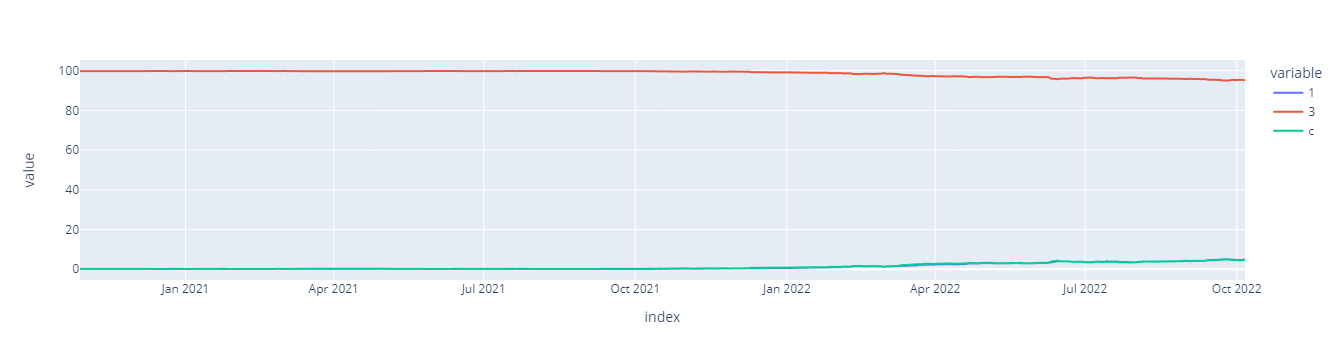

In [414]:
dd.assign(c=100-dd[3]).plot()

In [411]:
df_reg

3         1
2022-04-06  0.000  0.013906
2022-04-07  0.035 -0.050210
2022-04-08 -0.060  0.066637
2022-04-11 -0.005  0.020785
2022-04-12  0.125 -0.087676
...           ...       ...
2022-09-30 -0.005 -0.134482
2022-10-03  0.050 -0.065832
2022-10-04 -0.010  0.029259
2022-10-05 -0.045  0.103569
2022-10-06 -0.085  0.009255

[127 rows x 2 columns]